In [ ]:
!pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.5 which is incompatible.


In [ ]:
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
import mediapipe as mp
import math
import matplotlib.pyplot as plt
from mediapipe.tasks.python.components.containers import landmark as landmark_module
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import mediapipe as mp
from typing import List, Tuple, Union, Mapping, Optional


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles


#  if not results.multi_hand_world_landmarks:
#       continue
#     for hand_world_landmarks in results.multi_hand_world_landmarks:
#       mp_drawing.plot_landmarks(
#         hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54)

indices_to_keep = [0, 2, 5, 7, 8, 11, 12, 13, 14, 15, 16, 23, 24]
#                  0  1  2  3  4  5   6   7   8   9   10  11 12


POSE_CONNECTIONS = frozenset([(0,1),(0,2),(1,3),(2,4),(5,6),(6,8),(8,10),
                              (5,7),(7,9),(5,11),(6,12),(11,12)])


def extract_keypoints_and_bbox(hand_landmarks):
    x_min = min([lm.x for lm in hand_landmarks])
    y_min = min([lm.y for lm in hand_landmarks])
    x_max = max([lm.x for lm in hand_landmarks])
    y_max = max([lm.y for lm in hand_landmarks])

    width = x_max - x_min
    height = y_max - y_min
    bbox = (x_min, y_min, width, height)

    keypoints = [(lm.x, lm.y) for lm in hand_landmarks]

    return keypoints, bbox

def ensure_hands_order(hand_landmarks, handedness):
    """
    Sắp xếp tay sao cho tay phải luôn đứng trước tay trái.
    Nếu thiếu tay, thêm tay giả với tất cả tọa độ là 0.
    """
    # Sắp xếp tay theo handedness
    best_hands = {'Right': (None, -1), 'Left': (None, -1)}
    #print(handedness)
    # Iterate through handedness and hand_landmarks together
    for idx, (landmarks, hand_info) in enumerate(zip(hand_landmarks, handedness)):
        for category in hand_info:
            if category.category_name in best_hands:
                _, best_score = best_hands[category.category_name]
                if category.score > best_score:
                    best_hands[category.category_name] = (landmarks, category.score)

    # Preparing the ordered landmarks list
    ordered_landmarks = []

    # Append the best right hand if found, otherwise append an empty hand
    if best_hands['Right'][0] is not None:
        ordered_landmarks.append(best_hands['Right'][0])
    else:
        ordered_landmarks.append(create_empty_hand())

    # Append the best left hand if found, otherwise append an empty hand
    if best_hands['Left'][0] is not None:
        ordered_landmarks.append(best_hands['Left'][0])
    else:
        ordered_landmarks.append(create_empty_hand())

    return ordered_landmarks

def create_empty_hand():
    #Tạo một tay giả với tất cả tọa độ x, y, z là 0
    empty_landmarks = [
        landmark_module.NormalizedLandmark(x=0, y=0, z=0, visibility=0.0, presence=0.0)
        for _ in range(21)
    ]
    return empty_landmarks


def draw_hand_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

  plt.imshow(annotated_image)
  plt.show()
  return annotated_image


def filter_pose_landmarks(pose_detection_result):
    # Indices of landmarks to extract
    indices_to_extract = [0, 2, 5, 7, 8, 11, 12, 13, 14, 15, 16, 23, 24]

    # Check if the pose detection result has landmarks
    if not pose_detection_result.pose_landmarks:
        return []

    # Filter the landmarks based on the specified indices
    filtered_landmarks = [
        pose_detection_result.pose_landmarks[0][idx]
        for idx in indices_to_extract
    ]

    return filtered_landmarks

def draw_pose_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = [detection_result]
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    # Draw the pose landmarks.
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image


def process(input_path):
    is_video = input_path.lower().endswith(('.mp4', '.avi', '.mov'))
    results = []
    options1 = PoseLandmarkerOptions(
            base_options=BaseOptions(model_asset_path='/content/drive/MyDrive/hand_sigh_dataset/pose_landmarker_full.task'),
            running_mode=VisionRunningMode.IMAGE, num_poses = 1, min_pose_detection_confidence = 0.5, min_pose_presence_confidence = 0.5)
    pose_detector = PoseLandmarker.create_from_options(options1)

    if is_video:
        # Xử lý video
        options = HandLandmarkerOptions(
            base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
            running_mode=VisionRunningMode.VIDEO, num_hands=6, min_hand_detection_confidence = 0.1, min_hand_presence_confidence = 0.1, min_tracking_confidence = 0.65)

        with HandLandmarker.create_from_options(options) as landmarker:
            cap = cv2.VideoCapture(input_path)
            frame_rate = cap.get(cv2.CAP_PROP_FPS)
            frame_timestamp_ms = 0
            a = 0
            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break
                frame_result = {}
                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)
                pose_detection_result = pose_detector.detect(mp_image)
                if pose_detection_result.pose_landmarks:
                    #print(pose_detection_result)
                    pose_detection_result = filter_pose_landmarks(pose_detection_result)
                    #print(pose_detection_result)
                    # Đảm bảo thứ tự tay và xử lý normalize
                    result_hand = landmarker.detect_for_video(mp_image, frame_timestamp_ms)
                    ordered_hand_landmarks = ensure_hands_order(result_hand.hand_landmarks, result_hand.handedness)
                    #print(ordered_hand_landmarks)
                    frame_result['hand_landmarks'] = ordered_hand_landmarks
                    frame_result['pose_landmarks'] = pose_detection_result
                    results.append(frame_result)
                    # image = mp_image.numpy_view()
                    # annotated_image = draw_pose_landmarks_on_image(image,  pose_detection_result)
                    # annotated_image= draw_hand_landmarks_on_image(annotated_image, ordered_hand_landmarks)
                    a +=1

                frame_timestamp_ms += int(1000 / frame_rate)
            print(a)
            cap.release()

    else:
        # Xử lý ảnh
        options = HandLandmarkerOptions(
            base_options=BaseOptions(model_asset_path='hand_landmarker.task'),
            running_mode=VisionRunningMode.IMAGE,num_hands=6, min_hand_detection_confidence = 0.1, min_hand_presence_confidence = 0.1, min_tracking_confidence = 0.65 )
        with HandLandmarker.create_from_options(options) as landmarker:
            mp_image = mp.Image.create_from_file(input_path)
            #mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image_rgb) # Đọc từ một numpy array ảnh

            result = landmarker.detect(mp_image)
            print(result)
            pose_detection_result = pose_detector.detect(mp_image)
            print(pose_detection_result)
            frame_result = {}
            #print(result)

            handedness_categories = {category.category_name for hand_info in result.handedness for category in hand_info}
            if 'Left' in handedness_categories and 'Right' in handedness_categories:
                ordered_hand_landmarks = ensure_hands_order(result.hand_landmarks, result.handedness)
                frame_result['hand_landmarks'] = ordered_hand_landmarks
                results.append(frame_result)
                image = mp_image.numpy_view()
                image = image[:, :, :3]
                if pose_detection_result.pose_landmarks:
                    pose_detection_result = filter_pose_landmarks(pose_detection_result)
                    frame_result['pose_landmarks'] = pose_detection_result
                    print(image.shape)
                    annotated_image = draw_pose_landmarks_on_image(image,  pose_detection_result)
                else:
                  annotated_imagee = image
                annotated_image= draw_hand_landmarks_on_image(annotated_image, ordered_hand_landmarks)

    return results

In [ ]:
import numpy as np

def normalize_hand_landmarks(hand_landmarks):
    # Chia tay trái và phải
    left_hand = hand_landmarks[1] if len(hand_landmarks) > 1 else []
    right_hand = hand_landmarks[0] if len(hand_landmarks) > 0 else []

    def normalize_single_hand(hand):
        if not hand:
            return np.zeros(21*2)  # Nếu không có tay, trả về array toàn số 0

        # Lấy giá trị x và y từ landmarks
        landmarks_x_values = [lm.x for lm in hand]
        landmarks_y_values = [lm.y for lm in hand]

        # Tính toán bounding box dựa trên chiều rộng và chiều cao
        width = max(landmarks_x_values) - min(landmarks_x_values)
        height = max(landmarks_y_values) - min(landmarks_y_values)

        # Thiết lập delta_x và delta_y theo tỉ lệ width và height
        if width > height:
            delta_x = 0.3 * width
            delta_y = delta_x + ((width - height) / 2)*0.2
        else:
            delta_y = 0.3 * height
            delta_x = delta_y + ((height - width) / 2)*0.2


        # Điểm bắt đầu và kết thúc của bounding box để chuẩn hóa
        starting_point = [min(landmarks_x_values) - delta_x, min(landmarks_y_values) - delta_y]
        ending_point = [max(landmarks_x_values) + delta_x, max(landmarks_y_values) + delta_y]

        # Chuẩn hóa các điểm landmarks
        normalized_landmarks = []
        for lm in hand:
            if (ending_point[0] - starting_point[0]) == 0 or (starting_point[1] - ending_point[1]) == 0:
                normalized_landmarks.append((0.0,0.0))
                continue
            normalized_x = (lm.x - starting_point[0]) / (ending_point[0] - starting_point[0])
            normalized_y = (lm.y - ending_point[1]) / (starting_point[1] - ending_point[1])
            normalized_landmarks.append((normalized_x - 0.5, normalized_y - 0.5))

        return np.array(normalized_landmarks).flatten(), [starting_point, ending_point]


    # Chuẩn hóa tay trái và phải
    left_normalized, point1 = normalize_single_hand(left_hand)
    right_normalized, point2 = normalize_single_hand(right_hand)

    # Trả về kết quả đã chuẩn hóa
    return np.concatenate([right_normalized, left_normalized]), [point1, point2]
    #return [right_normalized, left_normalized], [point1, point2]

def normalize_pose_landmarks(pose_landmarks):

    landmarks_x_values = [lm.x for lm in pose_landmarks]
    landmarks_y_values = [lm.y for lm in pose_landmarks]

    # Lấy vị trí của vai trái (left_shoulder) và vai phải (right_shoulder)
    left_shoulder = (pose_landmarks[5].x, pose_landmarks[5].y)
    right_shoulder = (pose_landmarks[6].x, pose_landmarks[6].y)

    # Tính khoảng cách giữa vai trái và vai phải
    shoulder_distance = (((left_shoulder[0] - right_shoulder[0]) ** 2) +
                         ((left_shoulder[1] - right_shoulder[1]) ** 2)) ** 0.5
    head_metric = shoulder_distance

    # Tính toán starting_point và ending_point dựa trên thông tin neck và mắt trái
    neck_x = (pose_landmarks[5].x + pose_landmarks[6].x) / 2  # Giả sử cổ nằm giữa hai vai
    #print("neck", neck_x)
    left_eye_y = pose_landmarks[1].y


    starting_point = [neck_x - 3 * head_metric, left_eye_y - (head_metric)]
    ending_point = [neck_x + 3 * head_metric , starting_point[1] +  6 * head_metric]
  #print([starting_point[0], ending_point[0]])

    # Chuẩn hóa các điểm landmarks
    normalized_landmarks = []
    for lm in pose_landmarks:
        normalized_x = (lm.x - starting_point[0]) / (ending_point[0] - starting_point[0])
        normalized_y = (lm.y - ending_point[1]) / (starting_point[1] - ending_point[1])
        normalized_landmarks.append((normalized_x - 0.5, normalized_y - 0.5))

    return np.array(normalized_landmarks).flatten(), [starting_point, ending_point]

def normalize_landmarks(results):
    all_frames_normalized = []

    for frame_result in results:
        hand_normalized,a = normalize_hand_landmarks(frame_result['hand_landmarks'])
        pose_normalized,b = normalize_pose_landmarks(frame_result['pose_landmarks'])

        frame_normalized = np.concatenate([hand_normalized, pose_normalized])
        all_frames_normalized.append(frame_normalized)

    return np.array(all_frames_normalized)

In [ ]:
def pad_or_trim_landmarks(landmarks, target_length=200):

    current_length = landmarks.shape[0]

    if current_length < target_length:
        # Padding: Add zeros to the end
        pad_length = target_length - current_length
        padding = np.zeros((pad_length, landmarks.shape[1]))
        padded_landmarks = np.vstack((landmarks, padding))
        return padded_landmarks
    else:
        # Trimming: Slice the array to the target length
        return landmarks[:target_length, :]

In [ ]:
import torch


class GaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


if __name__ == "__main__":
    pass

In [ ]:
import logging
import torch


def train_epoch(model, dataloader, criterion, optimizer, device, scheduler=None):

    pred_correct, pred_all = 0, 0
    running_loss = 0.0

    for i, data in enumerate(dataloader):
        inputs, labels = data[0], data[1]
        inputs = inputs.squeeze(0).to(device, non_blocking=True)
        labels = labels.to(device, dtype=torch.long, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(inputs).expand(1, -1, -1)
        # print(outputs[0].shape)
        # print(labels[0].shape)
        loss = criterion(outputs[0], labels[0])
        loss.backward()
        optimizer.step()
        running_loss += loss

        # Statistics
        if int(torch.argmax(torch.nn.functional.softmax(outputs, dim=2))) == int(labels[0][0]):
            pred_correct += 1
        pred_all += 1

    if scheduler:
        scheduler.step(running_loss.item() / len(dataloader))

    return running_loss, pred_correct, pred_all, (pred_correct / pred_all)


def evaluate(model, dataloader, device, print_stats=False):

    pred_correct, pred_all = 0, 0
    stats = {i: [0, 0] for i in range(250)}

    for i, data in enumerate(dataloader):
        inputs, labels = data[0], data[1]
        inputs = inputs.squeeze(0).to(device, non_blocking=True)
        labels = labels.to(device, dtype=torch.long, non_blocking=True)

        outputs = model(inputs).expand(1, -1, -1)

        # Statistics
        if int(torch.argmax(torch.nn.functional.softmax(outputs, dim=2))) == int(labels[0][0]):
            stats[int(labels[0][0])][0] += 1
            pred_correct += 1

        stats[int(labels[0][0])][1] += 1
        pred_all += 1

    if print_stats:
        stats_1 = {key: value[0] / value[1] for key, value in stats.items() if value[1] != 0}
        print("Label accuracies statistics:")
        print(str(stats_1) + "\n")
        stats_test = {key: value[0] for key, value in stats.items() if value[1] != 0 }
        stats_real = {key: value[1] for key, value in stats.items() if value[1] != 0 }
        print(str(stats_test) + "\n")
        print(str(stats_real) + "\n")
        logging.info("Label accuracies statistics:")
        logging.info(str(stats) + "\n")

    return pred_correct, pred_all, (pred_correct / pred_all)


def evaluate_top_k(model, dataloader, device, k=5):

    pred_correct, pred_all = 0, 0

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs = inputs.squeeze(0).to(device)
        labels = labels.to(device, dtype=torch.long)

        outputs = model(inputs).expand(1, -1, -1)

        if int(labels[0][0]) in torch.topk(outputs, k).indices.tolist():
            pred_correct += 1

        pred_all += 1

    return pred_correct, pred_all, (pred_correct / pred_all)

In [ ]:
import copy
import torch

import torch.nn as nn
from typing import Optional


def _get_clones(mod, n):
    return nn.ModuleList([copy.deepcopy(mod) for _ in range(n)])

class DummySelfAttention(nn.Module):
    def __init__(self, batch_first=True):
        super(DummySelfAttention, self).__init__()
        # Keep the required attributes
        self.batch_first = batch_first

    def forward(self, *args, **kwargs):
        # Just return the input as-is
        return args[0]
class SPOTERTransformerDecoderLayer(nn.TransformerDecoderLayer):
    """
    Edited TransformerDecoderLayer implementation omitting the redundant self-attention operation as opposed to the
    standard implementation.
    """

    def __init__(self, d_model, nhead, dim_feedforward, dropout, activation):
        super(SPOTERTransformerDecoderLayer, self).__init__(d_model, nhead, dim_feedforward, dropout, activation)

        self.self_attn = DummySelfAttention()

    def forward(self, tgt: torch.Tensor, memory: torch.Tensor, tgt_mask: Optional[torch.Tensor] = None,
                memory_mask: Optional[torch.Tensor] = None, tgt_key_padding_mask: Optional[torch.Tensor] = None,
                memory_key_padding_mask: Optional[torch.Tensor] = None,
                tgt_is_causal=None,
                memory_is_causal=None) -> torch.Tensor:

        tgt = tgt + self.dropout1(tgt)
        tgt = self.norm1(tgt)
        #print('memory.shape',memory.shape)
        tgt2 = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask,
                                   key_padding_mask=memory_key_padding_mask)[0]
        #print('tgt2.shape',tgt2.shape)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)

        return tgt


class SPOTER(nn.Module):
    """
    Implementation of the SPOTER (Sign POse-based TransformER) architecture for sign language recognition from sequence
    of skeletal data.
    """

    def __init__(self, num_classes, hidden_dim=110):
        super().__init__()

        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim))
        self.pos = nn.Parameter(torch.cat([self.row_embed[0].unsqueeze(0).repeat(1, 1, 1)], dim=-1).flatten(0, 1).unsqueeze(0))
        self.class_query = nn.Parameter(torch.rand(1, hidden_dim))
        self.transformer = nn.Transformer(hidden_dim, 10, 6, 6)
        # Deactivate the initial attention decoder mechanism
        custom_decoder_layer = SPOTERTransformerDecoderLayer(self.transformer.d_model, self.transformer.nhead, 2048,
                                                             0.1, "relu")
        self.transformer.decoder.layers = _get_clones(custom_decoder_layer, self.transformer.decoder.num_layers)
        self.linear_class = nn.Linear(hidden_dim, num_classes)


    def forward(self, inputs):
        #print('input.shape',inputs.shape)
        h = torch.unsqueeze(inputs.flatten(start_dim=1), 1).float()
        #print('h.shape',h.shape)
        #print('class_query.shape',self.class_query.shape)
        #print('class_query.shape.unsqueeze(0)',self.class_query.unsqueeze(0).shape)
        h = self.transformer(self.pos + h, self.class_query.unsqueeze(0)).transpose(0, 1)
        #print('h2.shape',h.shape)
        res = self.linear_class(h)

        return res


if __name__ == "__main__":
    pass

In [ ]:
import torch
from torch.utils.data import Dataset
import h5py
import numpy as np

# Function to read HDF5 file (provided)
def read_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hf:
        data = {}
        for key in hf.keys():
            data[key] = hf[key][:]  # Read datasets into numpy arrays
        return data

# Custom Dataset class for loading data from HDF5
class HDF5Dataset(Dataset):
    def __init__(self, hdf5_file_path):
        # Load the data from the HDF5 file
        self.data = read_hdf5_file(hdf5_file_path)

        # Extract the results, labels, and label_encodes
        self.results = self.data['results']
        self.num_labels = self.data['num_label']
        self.label_encodes = self.data.get('label_encode', None)  # Handle case where label_encode may not exist

    def __len__(self):
        # Return the total number of samples
        return len(self.num_labels)

    def __getitem__(self, idx):
        # Load a single data point
        results = self.results[idx]

        # Get the label and label_encode if available
        num_label = self.num_labels[idx]
        label_encode = self.label_encodes[idx] if self.label_encodes is not None else None

        # Convert to torch tensor for PyTorch compatibility
        results = torch.tensor(results, dtype=torch.float32)

        num_label = torch.tensor([num_label], dtype=torch.long)
        if label_encode is not None:
          label_encode = torch.tensor(label_encode, dtype=torch.long)

        # Return a tuple of (results, label, label_encode)

        return results, num_label


In [ ]:
import numpy as np

from collections import Counter
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
def __balance_val_split(dataset, val_split=0.):
    # Lấy nhãn trực tiếp từ dataset
    labels = dataset.num_labels
    print(len(list(labels)))

    # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
    train_indices, val_indices = train_test_split(
        np.arange(len(labels)),  # Sử dụng len(labels) để có số lượng mẫu
        test_size=val_split,
        stratify=labels
    )

    train_dataset = Subset(dataset, indices=train_indices)
    val_dataset = Subset(dataset, indices=val_indices)

    return train_dataset, val_dataset


def __split_of_train_sequence(subset: Subset, train_split=1.0):
    if train_split == 1:
        return subset

    targets = np.array([subset.dataset.targets[i] for i in subset.indices])
    train_indices, _ = train_test_split(
        np.arange(targets.shape[0]),
        test_size=1 - train_split,
        stratify=targets
    )

    train_dataset = Subset(subset.dataset, indices=[subset.indices[i] for i in train_indices])

    return train_dataset


def __log_class_statistics(subset: Subset):
    train_classes = [subset.dataset.targets[i] for i in subset.indices]
    print(dict(Counter(train_classes)))

In [ ]:
import os
import argparse
import random
import logging
import torch

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from torchvision import transforms
from torch.utils.data import DataLoader
from pathlib import Path

def get_default_args():
    parser = argparse.ArgumentParser(add_help=False)

    parser.add_argument("--experiment_name", type=str, default="lsa_64_spoter",
                        help="Name of the experiment after which the logs and plots will be named")
    parser.add_argument("--num_classes", type=int, default=400, help="Number of classes to be recognized by the model")
    parser.add_argument("--hidden_dim", type=int, default=110,
                        help="Hidden dimension of the underlying Transformer model")
    parser.add_argument("--seed", type=int, default=379,
                        help="Seed with which to initialize all the random components of the training")

     # Data
    parser.add_argument("--training_set_path", type=str, default="/content/drive/MyDrive/hand_sigh_dataset/h5/train_datatuquay100.h5", help="Path to the training dataset h5 file")
    parser.add_argument("--testing_set_path", type=str, default="/content/drive/MyDrive/hand_sigh_dataset/h5/test_datatuquay100.h5", help="Path to the testing dataset h5 file")
    parser.add_argument("--experimental_train_split", type=float, default=1.0,
                        help="Determines how big a portion of the training set should be employed (intended for the "
                             "gradually enlarging training set experiment from the paper)")

    parser.add_argument("--validation_set", type=str, choices=["from-file", "split-from-train", "none"],
                        default="split-from-train", help="Type of validation set construction. See README for further rederence")
    parser.add_argument("--validation_set_path", type=str, default="", help="Path to the validation dataset CSV file")

    # Training hyperparameters
    parser.add_argument("--epochs", type=int, default=11, help="Number of epochs to train the model for")
    parser.add_argument("--lr", type=float, default=0.0001, help="Learning rate for the model training")
    parser.add_argument("--log_freq", type=int, default=1,
                        help="Log frequency (frequency of printing all the training info")

    #Checkpointing
    parser.add_argument("--save_checkpoints", type=bool, default=True,
                        help="Determines whether to save weights checkpoints")
    parser.add_argument("--checkpoints_path", type=str, default="/content/drive/MyDrive/hand_sigh_dataset/ckpt/ckpt_110/checkpoint_100_2_nopretrain.pth",
                        help="Path to cpkt")

    # Scheduler
    parser.add_argument("--scheduler_factor", type=int, default=0.1, help="Factor for the ReduceLROnPlateau scheduler")
    parser.add_argument("--scheduler_patience", type=int, default=5,
                        help="Patience for the ReduceLROnPlateau scheduler")

    # Gaussian noise normalization
    parser.add_argument("--gaussian_mean", type=int, default=0, help="Mean parameter for Gaussian noise layer")
    parser.add_argument("--gaussian_std", type=int, default=0.001,
                        help="Standard deviation parameter for Gaussian noise layer")

    # Visualization
    parser.add_argument("--plot_stats", type=bool, default=True,
                        help="Determines whether continuous statistics should be plotted at the end")
    parser.add_argument("--plot_lr", type=bool, default=True,
                        help="Determines whether the LR should be plotted at the end")
    parser.add_argument("-f", required=False)
    return parser



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def train(args):

    # MARK: TRAINING PREPARATION AND MODULES

    # Initialize all the random seeds
    random.seed(args.seed)
    np.random.seed(args.seed)
    os.environ["PYTHONHASHSEED"] = str(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    torch.backends.cudnn.deterministic = True
    g = torch.Generator()
    g.manual_seed(args.seed)

    # Set the output format to print into the console and save into LOG file
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(message)s",
        handlers=[
            logging.FileHandler(args.experiment_name + "_" + str(args.experimental_train_split).replace(".", "") + ".log")
        ]
    )

    # Set device to CUDA only if applicable
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    # Construct the model
    slrt_model = SPOTER(num_classes=args.num_classes, hidden_dim=args.hidden_dim)
    if args.checkpoints_path:
        if not torch.cuda.is_available():
          checkpoint = torch.load(args.checkpoints_path, map_location=torch.device('cpu'))
        else:
          checkpoint = torch.load(args.checkpoints_path)
        full_state_dict = checkpoint.state_dict()
        #new_state_dict = {k: v for k, v in full_state_dict.items() if 'linear_class' not in k}
        slrt_model.load_state_dict(full_state_dict, strict=False)
    slrt_model.train(True)
    slrt_model.to(device)

    # Construct the other modules
    cel_criterion = nn.CrossEntropyLoss().to(device)
    sgd_optimizer = optim.SGD(slrt_model.parameters(), lr=args.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(sgd_optimizer, factor=args.scheduler_factor, patience=args.scheduler_patience)

    # Ensure that the path for checkpointing and for images both exist
    Path("out-checkpoints/" + args.experiment_name + "/").mkdir(parents=True, exist_ok=True)
    Path("out-img/").mkdir(parents=True, exist_ok=True)


    # MARK: DATA

    # Training set
    transform = transforms.Compose([GaussianNoise(args.gaussian_mean, args.gaussian_std)])
    train_set = HDF5Dataset(args.training_set_path)

    # Validation set
    if args.validation_set == "from-file":
        val_set = HDF5Dataset(args.validation_set_path)
        val_loader = DataLoader(val_set, shuffle=True, generator=g, pin_memory=True if torch.cuda.is_available() else False)

    elif args.validation_set == "split-from-train":
        train_set, val_set = __balance_val_split(train_set, 0.2)
        val_loader = DataLoader(val_set, shuffle=True, generator=g, pin_memory=True if torch.cuda.is_available() else False)

    else:
        val_loader = None

    # Testing set
    if args.testing_set_path:
        eval_set = HDF5Dataset(args.testing_set_path)
        eval_loader = DataLoader(eval_set, shuffle=True, generator=g, pin_memory=True if torch.cuda.is_available() else False)

    else:
        eval_loader = None

    # Final training set refinements
    if args.experimental_train_split:
        train_set = __split_of_train_sequence(train_set, args.experimental_train_split)

    train_loader = DataLoader(train_set, shuffle=True, generator=g, pin_memory=True if torch.cuda.is_available() else False)

    #---------------------------------------------------------------------------------------------------------------------
    # MARK: TRAINING
    train_acc, val_acc = 0, 0
    losses, train_accs, val_accs = [], [], []
    lr_progress = []
    top_train_acc, top_val_acc = 0, 0
    checkpoint_index = 0

    if args.experimental_train_split:
        print("Starting " + args.experiment_name + "_" + str(args.experimental_train_split).replace(".", "") + "...\n\n")
        logging.info("Starting " + args.experiment_name + "_" + str(args.experimental_train_split).replace(".", "") + "...\n\n")

    else:
        print("Starting " + args.experiment_name + "...\n\n")
        logging.info("Starting " + args.experiment_name + "...\n\n")

    for epoch in range(args.epochs):
        train_loss, _, _, train_acc = train_epoch(slrt_model, train_loader, cel_criterion, sgd_optimizer, device)
        losses.append(train_loss.item() / len(train_loader))
        train_accs.append(train_acc)

        if val_loader:
            slrt_model.train(False)
            _, _, val_acc = evaluate(slrt_model, val_loader, device)
            slrt_model.train(True)
            val_accs.append(val_acc)

        # Save checkpoints if they are best in the current subset
        if args.save_checkpoints:
            if train_acc > top_train_acc:
                top_train_acc = train_acc
                torch.save(slrt_model, "out-checkpoints/" + args.experiment_name + "/checkpoint_t_" + str(checkpoint_index) + ".pth")

            if val_acc > top_val_acc:
                top_val_acc = val_acc
                torch.save(slrt_model, "out-checkpoints/" + args.experiment_name + "/checkpoint_v_" + str(checkpoint_index) + ".pth")

        if epoch % args.log_freq == 0:
            print("[" + str(epoch + 1) + "] TRAIN  loss: " + str(train_loss.item() / len(train_loader)) + " acc: " + str(train_acc))
            logging.info("[" + str(epoch + 1) + "] TRAIN  loss: " + str(train_loss.item() / len(train_loader)) + " acc: " + str(train_acc))

            if val_loader:
                print("[" + str(epoch + 1) + "] VALIDATION  acc: " + str(val_acc))
                logging.info("[" + str(epoch + 1) + "] VALIDATION  acc: " + str(val_acc))

            print("")
            logging.info("")

        # Reset the top accuracies on static subsets
        if epoch % 5 == 0:
            top_train_acc, top_val_acc = 0, 0
            checkpoint_index += 1

        lr_progress.append(sgd_optimizer.param_groups[0]["lr"])



    # MARK: TESTING

    print("\nTesting checkpointed models starting...\n")
    logging.info("\nTesting checkpointed models starting...\n")

    top_result, top_result_name = 0, ""

    if eval_loader:
        for i in range(checkpoint_index):
            for checkpoint_id in ["t", "v"]:
                # tested_model = VisionTransformer(dim=2, mlp_dim=108, num_classes=100, depth=12, heads=8)
                tested_model = torch.load("out-checkpoints/" + args.experiment_name + "/checkpoint_" + checkpoint_id + "_" + str(i) + ".pth")
                tested_model.train(False)
                _, _, eval_acc = evaluate(tested_model, eval_loader, device, print_stats=True)

                if eval_acc > top_result:
                    top_result = eval_acc
                    top_result_name = args.experiment_name + "/checkpoint_" + checkpoint_id + "_" + str(i)

                print("checkpoint_" + checkpoint_id + "_" + str(i) + "  ->  " + str(eval_acc))
                logging.info("checkpoint_" + checkpoint_id + "_" + str(i) + "  ->  " + str(eval_acc))

        print("\nThe top result was recorded at " + str(top_result) + " testing accuracy. The best checkpoint is " + top_result_name + ".")
        logging.info("\nThe top result was recorded at " + str(top_result) + " testing accuracy. The best checkpoint is " + top_result_name + ".")


    #PLOT 0: Performance (loss, accuracies) chart plotting
    if args.plot_stats:
        fig, ax = plt.subplots()
        ax.plot(range(1, len(losses) + 1), losses, c="#D64436", label="Training loss")
        ax.plot(range(1, len(train_accs) + 1), train_accs, c="#00B09B", label="Training accuracy")

        if val_loader:
            ax.plot(range(1, len(val_accs) + 1), val_accs, c="#E0A938", label="Validation accuracy")

        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

        ax.set(xlabel="Epoch", ylabel="Accuracy / Loss", title="")
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, shadow=True, fontsize="xx-small")
        ax.grid()

        fig.savefig("out-img/" + args.experiment_name + "_loss.png")

    # PLOT 1: Learning rate progress
    if args.plot_lr:
        fig1, ax1 = plt.subplots()
        ax1.plot(range(1, len(lr_progress) + 1), lr_progress, label="LR")
        ax1.set(xlabel="Epoch", ylabel="LR", title="")
        ax1.grid()

        fig1.savefig("out-img/" + args.experiment_name + "_lr.png")

    print("\nAny desired statistics have been plotted.\nThe experiment is finished.")
    logging.info("\nAny desired statistics have been plotted.\nThe experiment is finished.")

In [ ]:
parser = argparse.ArgumentParser("", parents=[get_default_args()], add_help=False)

args = parser.parse_args()
print(args)


Namespace(experiment_name='lsa_64_spoter', num_classes=400, hidden_dim=110, seed=379, training_set_path='/content/drive/MyDrive/hand_sigh_dataset/h5/train_datatuquay100.h5', testing_set_path='/content/drive/MyDrive/hand_sigh_dataset/h5/test_datatuquay100.h5', experimental_train_split=1.0, validation_set='split-from-train', validation_set_path='', epochs=11, lr=0.0001, log_freq=1, save_checkpoints=True, checkpoints_path='/content/drive/MyDrive/hand_sigh_dataset/ckpt/ckpt_110/checkpoint_100_2_nopretrain.pth', scheduler_factor=0.1, scheduler_patience=5, gaussian_mean=0, gaussian_std=0.001, plot_stats=True, plot_lr=True, f='/root/.local/share/jupyter/runtime/kernel-c18f0f7e-f8f1-45c8-b2ac-89bfc2cc57b0.json')


<ipython-input-11-9658e80b7d7c>:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(args.checkpoints_path)


9671
Starting lsa_64_spoter_10...


[1] TRAIN  loss: 0.05863087130431182 acc: 0.9740175801447777
[1] VALIDATION  acc: 0.958656330749354

[2] TRAIN  loss: 0.05998668256442081 acc: 0.9709152016546019
[2] VALIDATION  acc: 0.9622739018087856

[3] TRAIN  loss: 0.05832455150836996 acc: 0.9710444674250258
[3] VALIDATION  acc: 0.9643410852713178

[4] TRAIN  loss: 0.057388857947017195 acc: 0.9707859358841778
[4] VALIDATION  acc: 0.9622739018087856

[5] TRAIN  loss: 0.05625885546269067 acc: 0.969622543950362
[5] VALIDATION  acc: 0.9612403100775194

[6] TRAIN  loss: 0.055462905268388055 acc: 0.9718200620475698
[6] VALIDATION  acc: 0.9591731266149871

[7] TRAIN  loss: 0.05452101824818624 acc: 0.9741468459152016
[7] VALIDATION  acc: 0.9638242894056848

[8] TRAIN  loss: 0.05425616306750703 acc: 0.9728541882109617
[8] VALIDATION  acc: 0.9596899224806201

[9] TRAIN  loss: 0.05411470762329733 acc: 0.9713029989658738
[9] VALIDATION  acc: 0.9633074935400516

[10] TRAIN  loss: 0.053532794688085736 acc: 0.

<ipython-input-11-9658e80b7d7c>:154: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tested_model = torch.load("out-checkpoints/" + args.experiment_name + "/checkpoint_" + che

Label accuracies statistics:
{0: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 16: 1.0, 17: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 25: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 34: 1.0, 36: 1.0, 37: 1.0, 40: 1.0, 41: 1.0, 44: 1.0, 45: 1.0, 48: 1.0, 49: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 1.0, 61: 1.0, 62: 0.8, 63: 1.0, 64: 1.0, 65: 0.6, 66: 1.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0, 72: 1.0, 75: 1.0, 76: 1.0, 77: 1.0, 78: 0.6, 79: 1.0, 80: 0.8, 81: 1.0, 82: 1.0, 83: 1.0, 84: 1.0, 85: 1.0, 86: 0.0, 87: 0.8, 88: 1.0, 89: 0.4, 90: 1.0, 91: 1.0, 92: 1.0, 93: 1.0, 94: 1.0, 95: 1.0, 96: 1.0, 97: 1.0, 98: 0.8, 99: 1.0, 100: 1.0, 102: 1.0, 105: 1.0, 108: 1.0, 109: 1.0, 112: 1.0, 113: 1.0, 114: 1.0, 115: 1.0}

{0: 5, 3: 5, 4: 5, 5: 5, 16: 5, 17: 5, 20: 5, 21: 5, 22: 5, 25: 5, 28: 5, 29: 5, 30: 5, 31: 5, 34: 5, 36: 5, 37: 5, 40: 5, 41: 5, 44: 4, 45: 5, 48: 5, 49: 5, 51: 5, 52: 10, 53: 10, 54: 10, 55: 10, 56: 10, 57: 5, 58: 5, 59: 10, 60: 10, 61: 5, 62: 4, 63: 

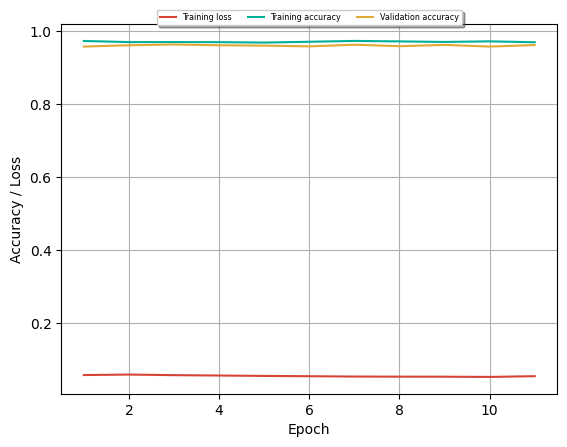

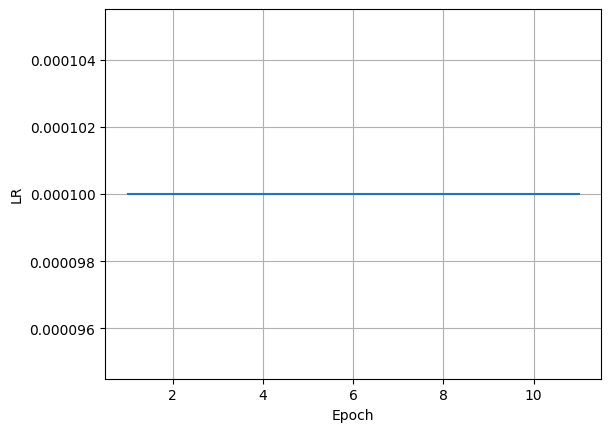

In [ ]:
train(args)

In [ ]:
x_process = process('/content/video_1.avi')

130


In [ ]:
normalized_results = pad_or_trim_landmarks(normalize_landmarks(x_process))

In [ ]:
results = torch.tensor(normalized_results, dtype=torch.float32)

In [ ]:
print(results.shape)

torch.Size([200, 110])


In [ ]:
if torch.cuda.is_available():
        device = torch.device("cuda")
else:
        device = torch.device("cpu")

In [ ]:
slrt_model = SPOTER(num_classes=400, hidden_dim=110)
checkpoint = torch.load("/content/drive/MyDrive/hand_sigh_dataset/ckpt/ckpt_110/checkpoint_100_2_nopretrain.pth", map_location=torch.device('cpu'))
full_state_dict = checkpoint.state_dict()
#new_state_dict = {k: v for k, v in full_state_dict.items() if 'linear_class' not in k}
slrt_model.load_state_dict(full_state_dict, strict=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
<ipython-input-16-8774fe3a162a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless th

<All keys matched successfully>

In [ ]:
slrt_model.to(device)

SPOTER(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-5): 6 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=110, out_features=110, bias=True)
          )
          (linear1): Linear(in_features=110, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=110, bias=True)
          (norm1): LayerNorm((110,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((110,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((110,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-5): 6 x SPOTERTransformerDecoderLayer(
          (self_attn): DummySelfAttention(

In [ ]:
inputs = results.squeeze(0).to(device)

In [ ]:
print(inputs.shape)

torch.Size([200, 110])


In [ ]:
outputs = slrt_model(inputs).expand(1, -1, -1)

In [ ]:
print(int(torch.argmax(torch.nn.functional.softmax(outputs, dim=2))))

4


In [ ]:
eval_set = HDF5Dataset("/content/drive/MyDrive/hand_sigh_dataset/h5/test_data_250.h5")


In [ ]:
g = torch.Generator()
eval_loader = DataLoader(eval_set, shuffle=True, generator=g, pin_memory=True if torch.cuda.is_available() else False)

In [ ]:
 _, _, eval_acc = evaluate(slrt_model, eval_loader, device, print_stats=True)

Label accuracies statistics:
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0, 22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0, 26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, 30: 1.0, 31: 1.0, 32: 1.0, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.0, 38: 1.0, 39: 1.0, 40: 1.0, 41: 1.0, 42: 1.0, 43: 1.0, 44: 1.0, 45: 1.0, 46: 1.0, 47: 1.0, 48: 1.0, 49: 1.0, 50: 1.0, 51: 1.0, 52: 1.0, 53: 1.0, 54: 1.0, 55: 1.0, 56: 1.0, 57: 1.0, 58: 1.0, 59: 1.0, 60: 1.0, 61: 1.0, 62: 1.0, 63: 1.0, 64: 1.0, 65: 1.0, 66: 1.0, 67: 1.0, 68: 1.0, 69: 1.0, 70: 1.0, 71: 1.0, 72: 1.0, 73: 1.0, 74: 1.0, 75: 1.0, 76: 1.0, 77: 1.0, 78: 1.0, 79: 1.0, 80: 1.0, 81: 1.0, 82: 1.0, 83: 1.0, 84: 1.0, 85: 1.0, 86: 1.0, 87: 1.0, 88: 1.0, 89: 1.0, 90: 1.0, 91: 1.0, 92: 1.0, 93: 1.0, 94: 1.0, 95: 1.0, 96: 1.0, 97: 1.0, 98: 1.0, 99: 1.0, 100: 1.0, 101: 1.0, 102: 1.0, 103: 1.0, 104: 1.0, 105: 1.0, 106: 1.0, 107: 1.0, 